Classification of Heart Disease Data

Introduction: 


Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2


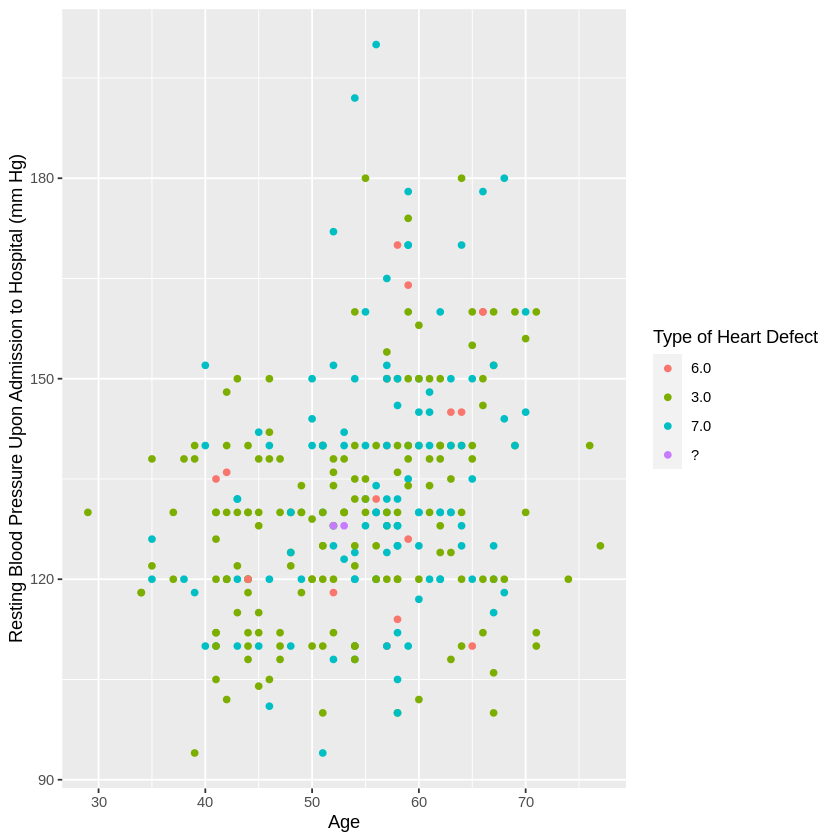

In [8]:
library(tidyverse)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data <- read_csv(url, col_names = FALSE)

data_cols <- rename(heart_data, age = X1,
               sex = X2,
               cp = X3,
               trestbps = X4,
               chol = X5,
               fbs = X6,
               restecg = X7,
               thalach = X8,
               exang = X9,
               oldpeak = X10,
               slope = X11,
               ca = X12,
               thal = X13,
               num = X14)


data <- mutate(data_cols, thal = as_factor(thal))
data

data_plot <- data %>%
ggplot(aes(x=age, y=trestbps, colour = thal)) +
geom_point() +
labs(x = "Age", y = "Resting Blood Pressure Upon Admission to Hospital (mm Hg)", colour = "Type of Heart Defect") 

data_plot